In [ ]:
import numpy as np

import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

import librosa
import deeplake

from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

c:\Users\Toazt\anaconda3\lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (4.1.14) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [5]:
def standardize_mfcc_length(mfcc_list, target_length=100):
    """Standardize MFCC matrices to a fixed length"""
    result = []
    for mfcc in mfcc_list:
        current_length = mfcc.shape[1]
        if current_length > target_length:
            # Truncate if longer than target
            standardized = mfcc[:, :target_length]
        else:
            # Pad with zeros if shorter
            padding = np.zeros((mfcc.shape[0], target_length - current_length))
            standardized = np.hstack([mfcc, padding])
        
        # Flatten the matrix for traditional ML models
        result.append(standardized.flatten())
    
    return np.array(result)

In [6]:
TARGET_LABELS = {"stop", "go", "up", "down", "forward", "backward"}

def extract_filtered_mfcc_features(dataset, n_mfcc=13, sample_rate=16000):
    """
    Extracts MFCC features only for the selected words.
    
    Parameters:
    - dataset: The Deeplake dataset containing audio tensors.
    - n_mfcc: Number of MFCC coefficients to extract.
    - sample_rate: Target sample rate for librosa processing.
    
    Returns:
    - X: NumPy array of MFCC features (num_samples, n_mfcc)
    - y: NumPy array of corresponding labels
    """
    
    X, y = [], []
    
    for i in range(len(dataset)):
        point_label = dataset.labels[i].data()['text'][0]  

        if point_label in TARGET_LABELS:  # Keep only target samples
            
            audio = dataset['audios'][i].numpy().squeeze()  # Extract audio data
            
            # Compute MFCC
            mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
            # mfcc_mean = np.mean(mfcc, axis=1)  # second method: Can take mean of factors for more simplistic feature set
            
            X.append(mfcc)
            y.append(point_label)
            
    return standardize_mfcc_length(X), np.array(y)

In [7]:
# Load dataset
dataset = deeplake.load('hub://activeloop/speech-commands-train')

# Extract features
X, y = extract_filtered_mfcc_features(dataset)


|

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/speech-commands-train



/

hub://activeloop/speech-commands-train loaded successfully.



 c:\Users\Toazt\anaconda3\lib\site-packages\deeplake\core\tensor.py:719: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


In [8]:


# Scale features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Encode labels so they are ints instead of strings for training the model
label_encoder = LabelEncoder()

# Convert string labels to integers
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)  # Use the same encoder to transform test labels

# Check class mapping
print(dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))


# Get amount of labels for output layer of neural network (how many classes we are distinguishing)
unique_labels = np.unique(y_train)  
highest_label = np.max(unique_labels)





{'down': 0, 'go': 1, 'stop': 2, 'up': 3}


In [ ]:
# Referenced:  https://www.tensorflow.org/tutorials/images/cnn
model = models.Sequential()
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(1300, 1)))
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))


c:\Users\Toazt\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Add dense layers on top
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(highest_label + 1))
# model.add(layers.Dense(highest_label + 1, activation='softmax'))

In [11]:
#Compile and train model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_test, y_test))

Epoch 1/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.5955 - loss: 1.0197 - val_accuracy: 0.7710 - val_loss: 0.6374
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7834 - loss: 0.5823 - val_accuracy: 0.8078 - val_loss: 0.5237
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.8605 - loss: 0.4005 - val_accuracy: 0.8277 - val_loss: 0.4584
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.8960 - loss: 0.3186 - val_accuracy: 0.8487 - val_loss: 0.4242
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9257 - loss: 0.2285 - val_accuracy: 0.8482 - val_loss: 0.4274
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9416 - loss: 0.1767 - val_accuracy: 0.8382 - val_loss: 0.4555
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.9638 - loss: 0.1231 - val_accuracy: 0.8403 - val_loss: 0.4725
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.9669 - loss: 0

60/60 - 1s - 9ms/step - accuracy: 0.8577 - loss: 1.7188
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       476
           1       0.85      0.85      0.85       476
           2       0.87      0.89      0.88       476
           3       0.84      0.85      0.85       476

    accuracy                           0.86      1904
   macro avg       0.86      0.86      0.86      1904
weighted avg       0.86      0.86      0.86      1904

Accuracy: 0.8576680672268907


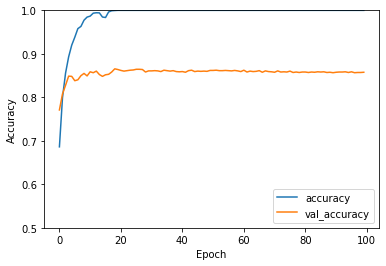

In [12]:
# Evaluate the model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)


from sklearn.metrics import classification_report, accuracy_score

# Get model predictions (logits)
y_pred_logits = model.predict(X_test)  # This will return raw logits

# Convert logits to class labels (since from_logits=True)
y_pred = np.argmax(y_pred_logits, axis=1)

# Print classification report
print(classification_report(y_test, y_pred))

# Compute accuracy separately
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)